## Doctor appointment booking System

This chat agent can interact with users and perform the following tasks:

    1. Select a doctor and choose a time slot for booking

    2. Cancel a booked appointment

    3. Reschedule a booked appointment based on availability

    4. Search for doctor details filtered by name, availability, specialty, and location

### 1. Connect with Gemini API

connect to the llm using google api key.

In [54]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
# Initialize Groq LLM
primary_llm = ChatGroq(
    api_key="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",
    model_name="qwen-qwq-32b",
    temperature=0.0

)

llm = ChatGroq(
    api_key="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",
    model_name="qwen-qwq-32b",
    temperature=0.0

)

In [1]:
# connect with gemini api
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [99]:
# initialize llm chat model
from langchain_google_genai import ChatGoogleGenerativeAI
from google.genai.types import GenerateContentConfig


system_instruction = """
                        You are a phone-agent assistant.  
                        
                        Keep all messages very short—just a single question or one answer.  
                        
                        Act as if you’re on a live call: no long explanations or chit-chat.  
                        
                        Always reference prior chat context and stay aligned with the conversation.  
                        
                    """


primary_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-05-20",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    config=GenerateContentConfig(
        system_instruction=system_instruction,
    ),
    # other params...
)

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-05-20",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    config=GenerateContentConfig(
        system_instruction=system_instruction,
    ),
    # other params...
)

### 2. State and Assistant class

This class is used to define specialized assistants based on each tasks

In [100]:
from typing import Annotated
from typing import Annotated, Literal, Optional

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages

# this method is used to update the current state of the graph
# this state is updated when the entry of the sub agent and when leave the skill state is updated
def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]

# state of the graph
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    dialog_state: Annotated[
        list[
            Literal[
                "primary_assistant",
                "reschedule",
                "cancel",
                "new",
            ]
        ],
        update_dialog_stack,
    ]
    user_name: str # name of the current user
    user_id: str # id of the current user


class Assistant:
    # this initialize a runnable that can be prompt template | llm with tools
    # by doing that we can make any assistant with same code
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        # if the llm not produce a result
        # it safely update the state with in a node using state = {**state, "messages": messages}
        # normally state is updated after the node is executed 
        # in this case 
        while True:
            
            # only passed trimmed messages to the llm
            # if len(state["messages"]) > 15:
            #     state["messages"] = state["messages"][-14:]

            result = self.runnable.invoke(state)
            
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        
        return {"messages": result, "dialog_state": None}

### 3. Completion of task and hand over to other assistant

This tool is called when the task is completed or the user intend to go another task

In [101]:
from pydantic import BaseModel, Field

class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }

# error comes because of gemini models
# reported issue in github
# from langchain_core.utils.function_calling import convert_to_openai_function
# CompleteOrEscalate = convert_to_openai_function(CompleteOrEscalate)


### 4. Create DataBase and insert sample data to that

This make a database and add some sample data 

In [102]:
DB_PATH = "hospital3.db"

In [58]:
import sqlite3
from datetime import datetime

# Step 1: Connect
DB_PATH = "hospital3.db"
conn = sqlite3.connect(DB_PATH) 
cursor = conn.cursor()

# Step 2: Create tables
cursor.execute("""
CREATE TABLE Doctor (
    Doctor_ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Doctor_Name TEXT,
    Specialization TEXT,
    Location TEXT,
    Rating REAL
)
""")

cursor.execute("""
CREATE TABLE Patient (
    Patient_ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Patient_Name TEXT,
    Age INTEGER
)
""")

cursor.execute("""
CREATE TABLE Appointment (
    Appointment_ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Appointment_Time TEXT,
    Appointment_Date TEXT,
    Doctor_ID INTEGER,
    Patient_ID INTEGER,
    FOREIGN KEY (Doctor_ID) REFERENCES Doctor(Doctor_ID),
    FOREIGN KEY (Patient_ID) REFERENCES Patient(Patient_ID)
)
""")

# Insert data into Doctor and Patient tables
doctors = [
    ("Dr. Alice Smith", "Cardiology", "New York", 4.7),
    ("Dr. Bob Johnson", "Neurology", "Los Angeles", 4.5),
    ("Dr. Clara Lee", "Pediatrics", "Chicago", 4.8)
]

patients = [
    ("John Doe", 30),
    ("Emily Davis", 25),
    ("Michael Brown", 45)
]

cursor.executemany("INSERT INTO Doctor (Doctor_Name, Specialization, Location, Rating) VALUES (?, ?, ?, ?)", doctors)
cursor.executemany("INSERT INTO Patient (Patient_Name, Age) VALUES (?, ?)", patients)

# Retrieve IDs
cursor.execute("SELECT Doctor_ID FROM Doctor ORDER BY Doctor_ID")
doctor_ids = [row[0] for row in cursor.fetchall()]

cursor.execute("SELECT Patient_ID FROM Patient ORDER BY Patient_ID")
patient_ids = [row[0] for row in cursor.fetchall()]

# Insert into Appointment table
appointments = [
    ("10:00", "2025-06-06", doctor_ids[0], patient_ids[0]),
    ("11:30", "2025-06-06", doctor_ids[1], patient_ids[1]),
    ("14:00", "2025-06-07", doctor_ids[2], patient_ids[2])
]

cursor.executemany("""
    INSERT INTO Appointment (Appointment_Time, Appointment_Date, Doctor_ID, Patient_ID)
    VALUES (?, ?, ?, ?)
""", appointments)

# Step 4: Commit and verify
conn.commit()

# Print the data
for row in cursor.execute("SELECT * FROM Appointment"):
    print(row)

# Close connection
conn.close()

OperationalError: table Doctor already exists

### 5. Tools for searching a Doctor and book an Appointment

In [103]:
from langchain_core.tools import tool
from typing import Optional, Dict, List
import sqlite3
import json

# Tool to search for a doctor by name
@tool
def search_for_doctor(name: Optional[str] = None) -> List[Dict]:
    """
    Search for doctors by name (or return all if name is None).

    Args:
        name (Optional[str]): The partial or full name of the doctor.

    Returns:
        List[Dict]: Doctors matching the search criteria.
    """
    conn = sqlite3.connect(DB_PATH)
    conn.row_factory = sqlite3.Row
    cursor = conn.cursor()

    if name:
        cursor.execute("""
            SELECT * FROM Doctor WHERE Doctor_Name LIKE ?
        """, (f"%{name}%",))
    else:
        cursor.execute("SELECT * FROM Doctor")

    results = [dict(row) for row in cursor.fetchall()]
    conn.close()
    return json.dumps(results)

# Tool to check a doctor's availability at a given date and time
@tool
def check_doctor_availability(doctor_id: int, date: str, time: str) -> Dict:
    """
    Check if a doctor is available at a given date and time.

    Args:
        doctor_id (int): The ID of the doctor.
        date (str): Date of the appointment in 'YYYY-MM-DD' format.
        time (str): Time of the appointment (e.g., '10:00').

    Returns:
        Dict: {"available": True/False}
    """
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    cursor.execute("""
        SELECT 1 FROM Appointment
        WHERE Doctor_ID = ? AND Appointment_Date = ? AND Appointment_Time = ?
    """, (doctor_id, date, time))

    result = cursor.fetchone()
    available = result is None
    conn.close()

    return json.dumps({"available": available})

# Tool for book an appoinment and add to the database
@tool
def book_appointment(user_id: int, doctor_id: int, date: str, time: str) -> Dict:
    """
    Book an appointment with a doctor if available at the given date and time.

    Args:
        user_id (int): The ID of the patient.
        doctor_id (int): The ID of the doctor.
        date (str): Appointment date in 'YYYY-MM-DD' format.
        time (str): Appointment time in 'HH:MM' format.

    Returns:
        Dict: {"success": True/False, "message": str}
    """
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    # Check if doctor is available
    cursor.execute("""
        SELECT 1 FROM Appointment
        WHERE Doctor_ID = ? AND Appointment_Date = ? AND Appointment_Time = ?
    """, (doctor_id, date, time))
    result = cursor.fetchone()

    if result:
        conn.close()
        return {"success": False, "message": "Doctor is not available at this date and time."}

    # Book appointment
    cursor.execute("""
        INSERT INTO Appointment (Appointment_Time, Appointment_Date, Doctor_ID, Patient_ID)
        VALUES (?, ?, ?, ?)
    """, (time, date, doctor_id, user_id))
    conn.commit()
    conn.close()

    return json.dumps({"success": True, "message": "Appointment booked successfully."})


In [104]:
from langchain_core.prompts import ChatPromptTemplate
from datetime import datetime

book_doctor_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling doctor new appointment bookings. "
            "The assistant delegates work to you whenever the user needs help finding a doctor or scheduling a new appointment. "
            "Search for doctors based on the user's preferences (name, specialization, location), and check their availability for a given date and time. "
            "Confirm the details with the user before attempting to book the appointment. "
            "Always confirm availability before booking. "
            "Do not proceed with a booking unless the relevant tool has successfully returned availability."
            "Do not invoke handoff_to_new_appointment tool."
            "\n\nAvailable tools:\n"
            "- `search_for_doctor`: Use this tool to find doctors based on user preferences (e.g., name, specialization, location).\n"
            "- `check_doctor_availability`: Use this tool to verify if a doctor is available at the requested date and time.\n"
            "- `book_appointment`: Use this tool to book an appointment only after confirming the user's intent and the doctor’s availability.\n"
            "- `CompleteOrEscalate`: Use this if the request is outside the scope (e.g., reschedule, cancel, insurance info, etc.)."
            "\n\nCurrent time: {time}."
            "\n\nSome examples where you should CompleteOrEscalate:\n"
            " - 'I want to reschedule an appointment'\n"
            " - 'I want to cancel an appointment'\n"
            " - 'I'm looking for medical insurance info'\n"
            " - 'I want to book a hospital room'\n"
            " - 'Actually, I’ll call the clinic myself'\n"
            " - 'I want to book a flight to the hospital location first'\n"
            " - 'Doctor appointment already confirmed'\n",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

book_appointment_tools = [check_doctor_availability, search_for_doctor, book_appointment]

llm_with_book_appointment_tools = llm.bind_tools(
    book_appointment_tools + [CompleteOrEscalate]
)

book_appointment_runnable = book_doctor_prompt | llm_with_book_appointment_tools

### 6. Make the book appointment sub graph

This sub graph is resposible for select a doctor and book an appointment 

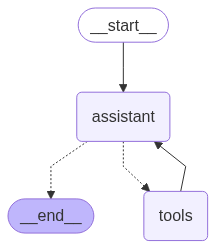

In [105]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition,ToolNode

# make a sample graph to check working
graph_builder = StateGraph(State)

graph_builder.add_node("tools", ToolNode(book_appointment_tools))
graph_builder.add_node("assistant", Assistant(book_appointment_runnable))
graph_builder.add_edge("tools", "assistant")
graph_builder.add_conditional_edges("assistant", tools_condition)
graph_builder.set_entry_point("assistant")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [62]:
thread = {"configurable": {"thread_id": "1"}}
inputs = {"messages": [{"role": "user", "content": "I want to book appoinment to Dr. Janith"}]}
for chunk in graph.stream(inputs, thread, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='I want to book appoinment to Dr. Janith', additional_kwargs={}, response_metadata={}, id='a8765bf8-51cd-47ef-817a-83ce3b49e8a0')], 'dialog_state': []}
{'messages': [HumanMessage(content='I want to book appoinment to Dr. Janith', additional_kwargs={}, response_metadata={}, id='a8765bf8-51cd-47ef-817a-83ce3b49e8a0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5k0md6qd6', 'function': {'arguments': '{"name":"Dr. Janith"}', 'name': 'search_for_doctor'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 281, 'prompt_tokens': 788, 'total_tokens': 1069, 'completion_time': 0.646269792, 'prompt_time': 0.06584726, 'queue_time': 0.44996354999999993, 'total_time': 0.712117052}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_a91d9c2cfb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c2dca839-41cd-4c06-b3fc-966f8d6363ea-0', tool_calls=[{'name': 'search_for_doctor', 'args': {'name': 'Dr. Janith'

In [10]:
inputs = {"messages": [{"role": "user", "content": "I want to book appoinment with Dr. Alice at 12 June 2025 at 10 am"}]}
for chunk in graph.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring
Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'search_for_doctor', 'arguments': '{"name": "Alice"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--2676a0a4-cf42-4146-b156-ba50deb32cac-0', tool_calls=[{'name': 'search_for_doctor', 'args': {'name': 'Alice'}, 'id': '839a06db-ee81-4505-ad40-ad2ad70a8a24', 'type': 'tool_call'}], usage_metadata={'input_tokens': 936, 'output_tokens': 17, 'total_tokens': 1071, 'input_token_details': {'cache_read': 0}}), 'dialog_state': None}}
{'tools': {'messages': [ToolMessage(content='[{"Doctor_ID": 1, "Doctor_Name": "Dr. Alice Smith", "Specialization": "Cardiology", "Location": "New York", "Rating": 4.7}]', name='search_for_doctor', id='202b8c57-3243-4418-8005-8f5ea8c2ae37', tool_call_id='839a06db-ee81-4505-ad40-ad2ad70a8a24')]}}


Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'check_doctor_availability', 'arguments': '{"doctor_id": 1.0, "date": "2025-06-12", "time": "10:00"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--ea62a325-8c0a-4f01-a352-b0aa58add0ff-0', tool_calls=[{'name': 'check_doctor_availability', 'args': {'doctor_id': 1.0, 'date': '2025-06-12', 'time': '10:00'}, 'id': '12051a18-460d-4c37-9089-872d6517b7c2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1011, 'output_tokens': 42, 'total_tokens': 1185, 'input_token_details': {'cache_read': 0}}), 'dialog_state': None}}
{'tools': {'messages': [ToolMessage(content='{"available": true}', name='check_doctor_availability', id='8b2215bd-2d9e-40a0-95f5-f80757bd1324', tool_call_id='12051a18-460d-4c37-9089-872d6517b7c2')]}}
{'assistant': {'messages': AIMess

In [11]:
inputs = {"messages": [{"role": "user", "content": "okey, can I book appoinment at 12 June 2025 at 10 am"}]}
for chunk in graph.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='Yes, I can book that for you. Could you please provide your user ID?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--b5a25ab7-d8a9-418a-9f6a-197c1db48007-0', usage_metadata={'input_tokens': 1127, 'output_tokens': 17, 'total_tokens': 1600, 'input_token_details': {'cache_read': 0}}), 'dialog_state': None}}


In [12]:
inputs = {"messages": [{"role": "user", "content": "my user id is 2"}]}
for chunk in graph.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring
Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'book_appointment', 'arguments': '{"doctor_id": 1.0, "user_id": 2.0, "date": "2025-06-12", "time": "10:00"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--17e807b0-a7d8-49fa-a735-bd9712e8f4dc-0', tool_calls=[{'name': 'book_appointment', 'args': {'doctor_id': 1.0, 'user_id': 2.0, 'date': '2025-06-12', 'time': '10:00'}, 'id': 'd4967dc0-fc74-4d79-b180-5e9974ef85d5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1152, 'output_tokens': 47, 'total_tokens': 1329, 'input_token_details': {'cache_read': 0}}), 'dialog_state': None}}
{'tools': {'messages': [ToolMessage(content='{"success": true, "message": "Appointment booked successfully."}', name='book_appointment', id='a2b13d9f-80c4-4bc9-bdae-25b513c08e47', tool_call_id='d4967dc0-fc74-4d79-b180-5

In [13]:
inputs = {"messages": [{"role": "user", "content": "my Id is 1"}]}
for chunk in graph.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content="I have your user ID as 1. However, I still need to know which doctor you would like to book an appointment with. Please provide the doctor's name or specialization.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--32b3bfba-9c59-4b33-9c12-c68c28ab88cf-0', usage_metadata={'input_tokens': 1066, 'output_tokens': 37, 'total_tokens': 1156, 'input_token_details': {'cache_read': 0}}), 'dialog_state': None}}


In [13]:
# check whether the database is updated

conn = sqlite3.connect(DB_PATH) 
cursor = conn.cursor()

for row in cursor.execute("SELECT * FROM Appointment"):
    print(row)

(1, '10:00', '2025-06-06', 1, 1)
(2, '11:30', '2025-06-06', 2, 2)
(3, '14:00', '2025-06-07', 3, 3)
(4, '10:00', '2025-06-12', 1, 2)


### 7. Tools for Search the appointment and delete that appoinment

This tools are responsible for search the booked appointment and delete if user confirm 

In [106]:
from langchain_core.tools import tool
import sqlite3
import json

@tool
def search_for_appointment(appointment_id: int) -> str:
    """
    Search for an appointment by its ID.

    Args:
        appointment_id (int): The ID of the appointment.

    Returns:
        str: JSON string with appointment details or failure message.
    """
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    cursor.execute("""
        SELECT Appointment_ID, Appointment_Date, Appointment_Time, Doctor_ID, Patient_ID
        FROM Appointment
        WHERE Appointment_ID = ?
    """, (appointment_id,))
    
    result = cursor.fetchone()
    conn.close()

    if result:
        return json.dumps({
            "success": True,
            "appointment": {
                "appointment_id": result[0],
                "date": result[1],
                "time": result[2],
                "doctor_id": result[3],
                "patient_id": result[4]
            }
        })
    else:
        return json.dumps({"success": False, "message": "Appointment not found."})


@tool
def cancel_appointment(appointment_id: int) -> str:
    """
    Cancel an existing appointment by its ID.

    Args:
        appointment_id (int): The ID of the appointment to cancel.

    Returns:
        str: JSON string with success/failure status and message.
    """
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    cursor.execute("SELECT 1 FROM Appointment WHERE Appointment_ID = ?", (appointment_id,))
    result = cursor.fetchone()

    if not result:
        conn.close()
        return json.dumps({"success": False, "message": "Appointment not found."})

    cursor.execute("DELETE FROM Appointment WHERE Appointment_ID = ?", (appointment_id,))
    conn.commit()
    conn.close()

    return json.dumps({"success": True, "message": "Appointment cancelled successfully."})

In [132]:
from langchain_core.prompts import ChatPromptTemplate
from datetime import datetime

cancel_appointment_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling doctor appointment cancellations. "
            "The primary assistant delegates work to you whenever the user wants to cancel an appointment. "
            "First, verify the appointment ID with the user. Then confirm the cancellation intent clearly before proceeding. "
            "Use the appropriate tool to cancel the appointment and inform the user of the result. "
            "Be clear and efficient in your responses. Do not cancel unless explicitly requested by the user."
            "Do not call handoff_to_cancel_appointment tool."
            "\n\nAvailable tools:\n"
            "- `search_for_appointment`: Use this tool to retrieve and verify appointment details using an appointment ID.\n"
            "- `cancel_appointment`: Use this tool to cancel an appointment after verifying the appointment ID and user intent.\n"
            "- `CompleteOrEscalate`: Use this when the user’s request is out of scope or ambiguous (e.g., not a cancellation, or a third-party request)."
            "\n\nCurrent time: {time}."
            "\n\nSome examples where you should CompleteOrEscalate:\n"
            " - 'I want to rebook instead of canceling'\n"
            " - 'What are the symptoms of flu?'\n"
            " - 'Actually, my friend needs to cancel, not me'\n"
            " - 'Appointment already canceled elsewhere'\n",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

cancel_appointment_tools = [search_for_appointment, cancel_appointment]

llm_with_cancel_appointment_tools = llm.bind_tools(
    cancel_appointment_tools + [CompleteOrEscalate]
)

cancel_appointment_runnable = cancel_appointment_prompt | llm_with_cancel_appointment_tools

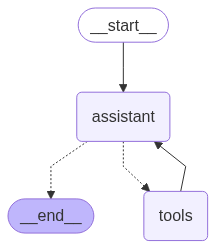

In [133]:
# make the graph responsible for cancel the appointment
graph_builder_cancel = StateGraph(State)

graph_builder_cancel.add_node("tools", ToolNode(cancel_appointment_tools))
graph_builder_cancel.add_node("assistant", Assistant(cancel_appointment_runnable))
graph_builder_cancel.add_edge("tools", "assistant")
graph_builder_cancel.add_conditional_edges("assistant", tools_condition)
graph_builder_cancel.set_entry_point("assistant")

memory_cancel = MemorySaver()
graph_cancel = graph_builder_cancel.compile(checkpointer=memory_cancel)

from IPython.display import Image, display

try:
    display(Image(graph_cancel.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [18]:
thread = {"configurable": {"thread_id": "2"}}
inputs = {"messages": [{"role": "user", "content": "I want to cancel my appoinment with Dr.Smith"}]}
for chunk in graph_cancel.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='I can help you with that. Do you have the appointment ID?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--73674f10-791e-49da-8ba3-e3c0384ac287-0', usage_metadata={'input_tokens': 528, 'output_tokens': 14, 'total_tokens': 570, 'input_token_details': {'cache_read': 0}}), 'dialog_state': None}}


In [19]:
inputs = {"messages": [{"role": "user", "content": "My appointment id is 3"}]}
for chunk in graph_cancel.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring
Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'search_for_appointment', 'arguments': '{"appointment_id": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--fa22f969-50aa-48af-9d25-2f455a676055-0', tool_calls=[{'name': 'search_for_appointment', 'args': {'appointment_id': 3.0}, 'id': '8d65251d-e0b8-4bf5-9a87-e4ee8a81f68e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 550, 'output_tokens': 19, 'total_tokens': 615, 'input_token_details': {'cache_read': 0}}), 'dialog_state': None}}
{'tools': {'messages': [ToolMessage(content='{"success": true, "appointment": {"appointment_id": 3, "date": "2025-06-07", "time": "14:00", "doctor_id": 3, "patient_id": 3}}', name='search_for_appointment', id='e07b3569-c53d-44da-8b6f-52e338649c77', tool_call_id='8d65251d-e0b8-4bf5-9a87-e4ee8a81f68e')]}}
{'as

In [20]:
inputs = {"messages": [{"role": "user", "content": "yes cancel it"}]}
for chunk in graph_cancel.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring
Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'cancel_appointment', 'arguments': '{"appointment_id": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--3b0f39fb-0bd9-4e0d-8cb3-2fd812f5e77c-0', tool_calls=[{'name': 'cancel_appointment', 'args': {'appointment_id': 3.0}, 'id': '25067514-6419-4b9e-ba3a-87a43ba31a1a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 675, 'output_tokens': 17, 'total_tokens': 692, 'input_token_details': {'cache_read': 0}}), 'dialog_state': None}}
{'tools': {'messages': [ToolMessage(content='{"success": true, "message": "Appointment cancelled successfully."}', name='cancel_appointment', id='66489bd8-b7e5-400e-b7d9-9e5418bb0723', tool_call_id='25067514-6419-4b9e-ba3a-87a43ba31a1a')]}}
{'assistant': {'messages': AIMessage(content='Your appointment with Dr. Smit

In [21]:
# check whether the database is updated

conn = sqlite3.connect(DB_PATH) 
cursor = conn.cursor()

for row in cursor.execute("SELECT * FROM Appointment"):
    print(row)

(1, '10:00', '2025-06-06', 1, 1)
(2, '11:30', '2025-06-06', 2, 2)
(4, '10:00', '2025-06-12', 1, 2)


### 8. Tools for Search the appointment and update that appoinment

This tools are responsible for search the booked appointment and Update if user confirm 

In [109]:
# 1. tool search the appointment by Id
# above tool can be used for that 

# 2. tool search for doctor
# this tool gives the doctor id 

# 3. tool search for doctor availability
# this tool search if the doctor is available at given time 

@tool
def update_appointment(appointment_id: int, date: str, time: str) -> str:
    """
    Update an existing appointment to a new date and time if the doctor is available.

    Args:
        appointment_id (int): ID of the appointment to update.
        date (str): New date in 'YYYY-MM-DD' format.
        time (str): New time in 'HH:MM' format.

    Returns:
        str: JSON string with success/failure status and message.
    """
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    # Get doctor ID from appointment
    cursor.execute("SELECT Doctor_ID FROM Appointment WHERE Appointment_ID = ?", (appointment_id,))
    result = cursor.fetchone()
    if not result:
        conn.close()
        return json.dumps({"success": False, "message": "Appointment not found."})
    
    doctor_id = result[0]

    # Check if doctor is available at new date and time
    cursor.execute("""
        SELECT 1 FROM Appointment
        WHERE Doctor_ID = ? AND Appointment_Date = ? AND Appointment_Time = ? AND Appointment_ID != ?
    """, (doctor_id, date, time, appointment_id))
    
    if cursor.fetchone():
        conn.close()
        return json.dumps({"success": False, "message": "Doctor is not available at the requested time."})

    # Update the appointment
    cursor.execute("""
        UPDATE Appointment
        SET Appointment_Date = ?, Appointment_Time = ?
        WHERE Appointment_ID = ?
    """, (date, time, appointment_id))
    
    conn.commit()
    conn.close()

    return json.dumps({"success": True, "message": "Appointment updated successfully."})

In [110]:

VALID_CANCEL_TOOLS = {tool.name for tool in cancel_appointment_tools}
VALID_BOOK_TOOLS = {tool.__repr_name__ for tool in book_appointment_tools}

print(VALID_CANCEL_TOOLS)

{'search_for_appointment', 'cancel_appointment'}


In [111]:
from langchain_core.prompts import ChatPromptTemplate
from datetime import datetime
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

update_appointment_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling doctor appointment rescheduling. "
            "The primary assistant delegates work to you whenever the user wants to change the date or time of a scheduled appointment. "
            "Start by verifying the appointment ID using the appropriate tool. "
            "Then check the doctor's availability at the new requested date and time. "
            "Only proceed with the update if the doctor is available and the appointment exists. "
            "If the doctor is unavailable, offer alternative time slots or ask the user for a different time. "
            "Always confirm the user's intent and ensure all tools complete successfully before confirming the update."
            "Do not invoke handoff_to_reschedule_appointment tool."
            "\n\nAvailable tools:\n"
            "- `search_for_appointment`: Use to fetch and validate an existing appointment by ID.\n"
            "- `check_doctor_availability`: Use to verify if the doctor is free at the new requested date/time.\n"
            "- `search_for_doctor`: Use to retrieve doctor info if needed (e.g., ID or specialties).\n"
            "- `update_appointment`: Use to reschedule the appointment once all conditions are met.\n"
            "- `CompleteOrEscalate`: Use to transfer to the main assistant for unsupported requests."
            "\n\nCurrent time: {time}."
            "\n\nSome examples where you should CompleteOrEscalate:\n"
            " - 'I want to cancel my appointment instead'\n"
            " - 'Do you know the doctor's specialties?'\n"
            " - 'Actually I’ll call the hospital directly'\n"
            " - 'Appointment already updated elsewhere'\n",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

# tools for update the appoinment
update_appointment_tools = [check_doctor_availability, search_for_doctor, update_appointment, search_for_appointment]
llm_with_update_appointment_tools = llm.bind_tools(
    update_appointment_tools + [CompleteOrEscalate]
)

update_appointment_runnable = update_appointment_prompt | llm_with_book_appointment_tools

VALID_UPDATE_TOOLS = {tool.name for tool in update_appointment_tools}
VALID_CANCEL_TOOLS = {tool.name for tool in cancel_appointment_tools}
VALID_BOOK_TOOLS = {tool.name for tool in book_appointment_tools}

# this is conditional edge to route update appoinment agent tools
def route_reschedule_assistant(state: State):
    route = tools_condition(state)
    # if the llm answered and go to the end
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    tool_calls_name_dict = {tool["name"] for tool in tool_calls}

    # if it call tool name complete navigate to leave_skill
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    
    # if not valid tool is called go to the end
    if not tool_calls_name_dict.issubset(VALID_UPDATE_TOOLS):
        return END 
    
    # if it call other tool route to reschedule_tools node
    return "reschedule_tools"

# this is conditional edge to route update appoinment agent tools
def route_new_assistant(state: State):
    route = tools_condition(state)
    # if the llm answered and go to the end
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    tool_calls_name_dict = {tool["name"] for tool in tool_calls}

    # if it call tool name complete navigate to leave_skill
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    
    # if not valid tool is called go to the end
    if not tool_calls_name_dict.issubset(VALID_BOOK_TOOLS):
        return END 
    
    # if it call other tool route to reschedule_tools node
    return "new_appointment_tools"

# this is conditional edge to route update appoinment agent tools
def route_cancel_assistant(state: State):
    route = tools_condition(state)
    # if the llm answered and go to the end
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    tool_calls_name_dict = {tool["name"] for tool in tool_calls}
    
    # if it call tool name complete navigate to leave_skill
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    
    # if not valid tool is called go to the end
    if not tool_calls_name_dict.issubset(VALID_CANCEL_TOOLS):
        return END 
    
    # if it call other tool route to reschedule_tools node
    return "cancel_appointment_tools"

### 9. Make sub graph for update an appointment when user need

This is sample graph for cancel an appointment  

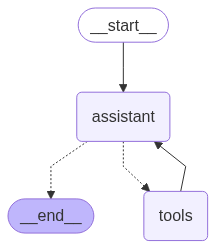

In [112]:
# make the graph responsible for update the appointment
graph_builder_update = StateGraph(State)

graph_builder_update.add_node("tools", ToolNode(update_appointment_tools))
graph_builder_update.add_node("assistant", Assistant(update_appointment_runnable))
graph_builder_update.add_edge("tools", "assistant")
graph_builder_update.add_conditional_edges("assistant", tools_condition)
graph_builder_update.set_entry_point("assistant")

memory_update = MemorySaver()
graph_update = graph_builder_update.compile(checkpointer=memory_update)

from IPython.display import Image, display

try:
    display(Image(graph_cancel.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [28]:
thread = {"configurable": {"thread_id": "3"}}
inputs = {"messages": [{"role": "user", "content": "I want to reshedule my appointment"}]}
for chunk in graph_update.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content='I can help you with that. Please provide me with the appointment ID, the original date and time of the appointment, and the new preferred date and time for your appointment.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--c47f34f7-ca19-45bb-9a84-aae385a8728c-0', usage_metadata={'input_tokens': 824, 'output_tokens': 35, 'total_tokens': 1036, 'input_token_details': {'cache_read': 0}}), 'dialog_state': None}}


In [29]:
inputs = {"messages": [{"role": "user", "content": "my appointment id is 4"}]}
for chunk in graph_update.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content="I have your appointment ID as 4. To reschedule, I need a few more details. Could you please provide:\n\n1.  The original date and time of your appointment (e.g., 'YYYY-MM-DD HH:MM')?\n2.  The new preferred date and time for your appointment (e.g., 'YYYY-MM-DD HH:MM')?\n3.  The ID of the doctor for this appointment?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--f981ae6b-906c-4d4e-9351-a354ef9271b6-0', usage_metadata={'input_tokens': 867, 'output_tokens': 94, 'total_tokens': 2119, 'input_token_details': {'cache_read': 0}}), 'dialog_state': None}}


In [30]:
inputs = {"messages": [{"role": "user", "content": "i want to shedule at 10 am 6 th June"}]}
for chunk in graph_update.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content="I understand you want to reschedule your appointment to June 6th at 10 AM. I still need the following information to proceed:\n\n1.  The original date and time of your appointment.\n2.  The ID of the doctor for this appointment.\n\nOnce I have these details, I can check the doctor's availability and reschedule your appointment.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--e8d9a124-ec94-4a53-9970-6d64708504e0-0', usage_metadata={'input_tokens': 977, 'output_tokens': 74, 'total_tokens': 1119, 'input_token_details': {'cache_read': 0}}), 'dialog_state': None}}


In [31]:
inputs = {"messages": [{"role": "user", "content": "i want to shedule at 12 PM noon 6 th June 2025"}]}
for chunk in graph_update.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


{'assistant': {'messages': AIMessage(content="I understand you want to reschedule your appointment to June 6th, 2025, at 12 PM. I still need the following information to proceed:\n\n1.  The original date and time of your appointment.\n2.  The ID of the doctor for this appointment.\n\nOnce I have these details, I can check the doctor's availability and reschedule your appointment.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--ecee14e2-32ec-4a09-af5b-af1b1bec56f5-0', usage_metadata={'input_tokens': 1073, 'output_tokens': 81, 'total_tokens': 1210, 'input_token_details': {'cache_read': 0}}), 'dialog_state': None}}


In [ ]:
inputs = {"messages": [{"role": "user", "content": "doctor id is 2"}]}
for chunk in graph_update.stream(inputs, thread, stream_mode="updates"):
    print(chunk)

In [ ]:
# check whether the database is updated

conn = sqlite3.connect(DB_PATH) 
cursor = conn.cursor()

for row in cursor.execute("SELECT * FROM Appointment"):
    print(row)

In [ ]:
from pydantic import __version__
__version__

### 9. Handling the multi agent systems

When pass to the other agent the primary agent (Supervisor) ensure that all the data is gathered to pass to the specialized agent.

1. reschedule : reschedule an appointment based on the user booked id and the doctor availability 
2. cancel : cancel an appointment based on user provide appoinment id
3. new : book an new appointment based on user time and the doctor availability 

these are the 3 main agent state 

In [113]:
from typing import Callable
from langchain_core.messages import ToolMessage

# create a entry node for each of the specialized agents
def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user."
                    " booking, update, other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

### 10. Make tools for call by the primary agent 

This tool will deside the paths of the agent

In [114]:
from pydantic import BaseModel, Field

# this tool is called when the supervisor deside to hand over to the reshedule agent
class handoff_to_reschedule_appointment(BaseModel):
    """Transfers work to a specialized assistant to reschedule the appointment with a doctor."""
    request: str = Field(
        description="Any necessary follow-up questions the reschedule assistant should clarify before proceeding."
    )

class handoff_to_cancel_appointment(BaseModel):
    """Transfers work to a specialized assistant to cancel an appointment with a doctor."""
    request: str = Field(
        description="Any necessary follow-up questions the cancellation assistant should clarify before proceeding."
    )

class handoff_to_new_appointment(BaseModel):
    """Transfers work to a specialized assistant to book a new appointment with a doctor."""
    request: str = Field(
        description="Any necessary follow-up questions the booking assistant should clarify before proceeding."
    )

In [115]:
from langchain_core.prompts import ChatPromptTemplate
from datetime import datetime

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for a medical clinic. "
            "Your primary role is to answer general inquiries and assist with doctor availability and appointment information. "
            "If a user wants to book a new appointment, cancel an existing one, or reschedule, "
            "quietly delegate the task to the appropriate specialized assistant using the correct tool. "
            "You do not handle bookings or cancellations directly—only the specialized assistants have that permission."
            "The user is unaware of these assistants, so do not mention them—just make the necessary function call quietly."
            "Always verify details and be thorough in providing accurate and helpful information."
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

# tools that are with primary assistant
primary_assistant_tools = [handoff_to_reschedule_appointment,
                            handoff_to_cancel_appointment,
                            handoff_to_new_appointment,
                            check_doctor_availability, 
                            search_for_doctor,]

llm_with_primary_assistant_tools = primary_llm.bind_tools(primary_assistant_tools)
# Specialized assistants for appointment management
primary_assistant_runnable = primary_assistant_prompt | llm_with_primary_assistant_tools

In [116]:
# This node will be shared for exiting all specialized assistants
# this node will share when it leave the skill and when it called it set state as 
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    # when it return to the main assistant only provide the reason to that 
    messages = [state.get("messages")[-1]]
    print("debug: ",messages)
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }

In [117]:
# condition for primary assistant routing
def route_primary_assistant(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == handoff_to_reschedule_appointment.__name__:
            return "enter_reschedule_appointment"
        elif tool_calls[0]["name"] == handoff_to_cancel_appointment.__name__:
            return "enter_cancel_appointment"
        elif tool_calls[0]["name"] == handoff_to_new_appointment.__name__:
            return "enter_new_appointment"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")

### 11. User info node (condition and the node)

This node use to route back to the correct workflow again when user again start the graph

In [118]:
from typing import Annotated, Literal, Optional

# condition to route again to current work flow from the start
# this condition is checked at the user info node and route to correct node
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "reschedule",
    "cancel",
    "new",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    print("Current dialog State is : ",dialog_state)
    if not dialog_state:
        return "primary_assistant"
    print("debug: ",dialog_state[-1])
    return dialog_state[-1]

# this is the first workflow routing node
def user_info(state: State)-> State:
    # simply do nothing to the state in the user info
    return {"dialog_state":None}

In [119]:
from langchain_core.runnables import RunnableLambda

from langchain_core.runnables import RunnableLambda
from typing import List, Callable, Dict, Any
import json

# Fallback handler
def handle_tool_error(err: Exception) -> str:
    return json.dumps({
        "success": False,
        "message": f"Tool execution failed: {str(err)}"
    })

# Tool node wrapper with filtering and fallback
def create_tool_node_with_fallback(tools: List[Callable]) -> Dict:
    # Filter only tools that are not None and are callable
    available_tools = [tool for tool in tools if callable(tool)]

    if not available_tools:
        # No tools are available
        return RunnableLambda(lambda _: json.dumps({
            "success": False,
            "message": "No available tool found. Please try a different one."
        }))

    # Create ToolNode and attach fallback
    return ToolNode(available_tools,handle_tool_errors=(
        "Can't use 42 as a first operand, you must switch operands!"  
    )).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

### 12. Make the connections to all agents

This contain the all the connection between Supervisor and the specialized agents

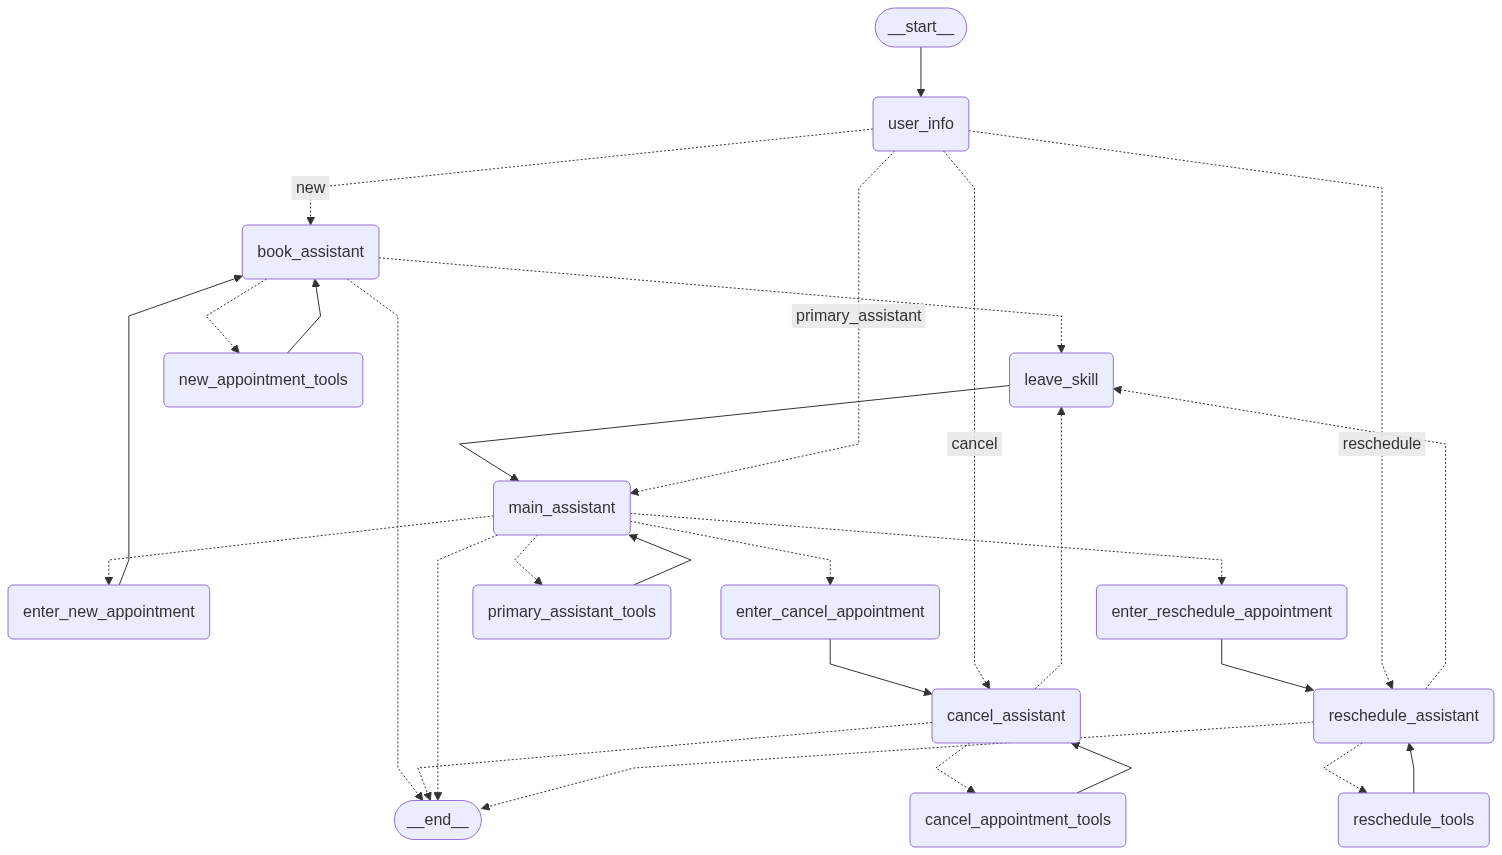

In [140]:
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition,ToolNode

# make the simple graph to test the functionality
all_graph_builder = StateGraph(State)

# add nodes
all_graph_builder.add_node("user_info", user_info)
all_graph_builder.add_node("main_assistant", Assistant(primary_assistant_runnable))
all_graph_builder.add_node("reschedule_assistant", Assistant(update_appointment_runnable))
all_graph_builder.add_node("cancel_assistant", Assistant(cancel_appointment_runnable))
all_graph_builder.add_node("book_assistant", Assistant(book_appointment_runnable))

# add leave skill node
all_graph_builder.add_node("leave_skill", pop_dialog_state)

# make a entry node to the new appointment
all_graph_builder.add_node("enter_new_appointment", create_entry_node("new_appointment_booking", "new"))
all_graph_builder.add_node("enter_cancel_appointment", create_entry_node("cancel_appointment", "cancel"))
all_graph_builder.add_node("enter_reschedule_appointment", create_entry_node("reschedule_appointment", "reschedule"))
all_graph_builder.add_node("primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools))

# add node to connect to the each specialized assistant
# "reschedule_tools" 
# "cancel_appointment_tools" "new_appointment_tools"
all_graph_builder.add_node("reschedule_tools", create_tool_node_with_fallback(update_appointment_tools))
all_graph_builder.add_node("cancel_appointment_tools", create_tool_node_with_fallback(cancel_appointment_tools))
all_graph_builder.add_node("new_appointment_tools", create_tool_node_with_fallback(book_appointment_tools))

# again route back to the current node as react agent
all_graph_builder.add_edge("reschedule_tools", "reschedule_assistant")
all_graph_builder.add_edge("cancel_appointment_tools", "cancel_assistant")
all_graph_builder.add_edge("new_appointment_tools", "book_assistant")

# add the entry level connections to primary assistant
all_graph_builder.add_edge(START, "user_info")
all_graph_builder.add_edge("user_info", "main_assistant")
all_graph_builder.add_conditional_edges("main_assistant", route_primary_assistant,
                                        ["primary_assistant_tools",
                                         "enter_new_appointment",
                                         "enter_cancel_appointment",
                                         "enter_reschedule_appointment",
                                         END])
all_graph_builder.add_edge("primary_assistant_tools", "main_assistant")

# make connections to each specialized agents
all_graph_builder.add_edge("enter_new_appointment", "book_assistant")
all_graph_builder.add_edge("enter_cancel_appointment", "cancel_assistant")
all_graph_builder.add_edge("enter_reschedule_appointment", "reschedule_assistant")

# connect leave skill to primary assistant
all_graph_builder.add_edge("leave_skill", "main_assistant")


# add routing to tools and leave skill and end to each assistant
all_graph_builder.add_conditional_edges("book_assistant", route_new_assistant, ["leave_skill","new_appointment_tools",END])
all_graph_builder.add_conditional_edges("cancel_assistant", route_cancel_assistant, ["leave_skill","cancel_appointment_tools",END])
all_graph_builder.add_conditional_edges("reschedule_assistant", route_reschedule_assistant, ["leave_skill","reschedule_tools",END])

# add routing when again start
all_graph_builder.add_conditional_edges("user_info", route_to_workflow, {"new": "book_assistant", 
                                                                         "reschedule": "reschedule_assistant", 
                                                                         "cancel": "cancel_assistant", 
                                                                         "primary_assistant": "main_assistant",})

memory_all = MemorySaver()
all_graph = all_graph_builder.compile(checkpointer= memory_all)

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(all_graph.get_graph(xray=True).draw_mermaid_png(curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            background_color="white",
            padding=10,)))

In [135]:
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

### 13. Debug the agent using langfuse

In [136]:
from langfuse import Langfuse
import os

langfuse = Langfuse(
  secret_key="sk-lf-dc4b0843-f2de-4bd8-aea0-f852d023b234",
  public_key="pk-lf-95bfeee2-5ed3-4ea7-ae8e-a84c0e1d8277",
  host="https://cloud.langfuse.com"
)

# get keys for your project from https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-95bfeee2-5ed3-4ea7-ae8e-a84c0e1d8277"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-dc4b0843-f2de-4bd8-aea0-f852d023b234"

In [137]:
from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

In [141]:
thread = {"configurable": {"thread_id": "1"}, "callbacks": [langfuse_handler]}
inputs = {"messages": [{"role": "user", "content": "I want new appointment with Alice",}]}

_printed = set()
for event in all_graph.stream(inputs, thread, stream_mode="values"):
    _print_event(event, _printed)

================================ Human Message =================================

I want new appointment with Alice
Current dialog State is :  []


Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


================================== Ai Message ==================================
Tool Calls:
  handoff_to_new_appointment (29f93c01-40fa-4aa6-be55-74e4beb25409)
 Call ID: 29f93c01-40fa-4aa6-be55-74e4beb25409
  Args:
    request: The user wants to book a new appointment with Alice.
Currently in:  new
================================= Tool Message =================================

The assistant is now the new_appointment_booking. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. booking, update, other action is not complete until after you have successfully invoked the appropriate tool. If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control. Do not mention who you are - just act as the proxy for the assistant.


Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


Currently in:  new
================================== Ai Message ==================================
Tool Calls:
  search_for_doctor (cc06253c-06e7-4256-933e-fddba05e3502)
 Call ID: cc06253c-06e7-4256-933e-fddba05e3502
  Args:
    name: Alice
Currently in:  new
================================= Tool Message =================================
Name: search_for_doctor

[{"Doctor_ID": 1, "Doctor_Name": "Dr. Alice Smith", "Specialization": "Cardiology", "Location": "New York", "Rating": 4.7}]
Currently in:  new
================================== Ai Message ==================================

I found Dr. Alice Smith. What date and time would you like to book the appointment?


In [142]:
thread = {"configurable": {"thread_id": "1"}, "callbacks": [langfuse_handler]}
inputs = {"messages": [{"role": "user", "content": "I want new appointment with Alice.I want 2pm at 10th July 2025",}]}

_printed = set()
for event in all_graph.stream(inputs, thread, stream_mode="values"):
    _print_event(event, _printed)

Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


Currently in:  new
================================ Human Message =================================

I want new appointment with Alice.I want 2pm at 10th July 2025
Current dialog State is :  ['new']
debug:  new
Currently in:  new


Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


Currently in:  new
================================== Ai Message ==================================
Tool Calls:
  check_doctor_availability (c2f0192f-bae4-459b-8217-d45b6d57417a)
 Call ID: c2f0192f-bae4-459b-8217-d45b6d57417a
  Args:
    doctor_id: 1.0
    date: 2025-07-10
    time: 14:00
Currently in:  new
================================= Tool Message =================================
Name: check_doctor_availability

{"available": true}


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents[8].parts: contents.parts must not be empty.


In [130]:
inputs = {"messages": [{"role": "user", "content": " my id is 2 i want to book that appointment",}], "dialog_state":None}

_printed = set()
for event in all_graph.stream(inputs, thread, stream_mode="values"):
    _print_event(event, _printed)

================================ Human Message =================================

 my id is 2 i want to book that appointment
Current dialog State is :  []


Key 'example' is not supported in schema, ignoring
Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


================================== Ai Message ==================================
Tool Calls:
  handoff_to_new_appointment (7f7e5f8e-1cc1-4e7f-985a-f826175ba05b)
 Call ID: 7f7e5f8e-1cc1-4e7f-985a-f826175ba05b
  Args:
    request: Could you please specify which appointment you would like to book? I need more details such as the doctor, date, and time.
Currently in:  new
================================= Tool Message =================================

The assistant is now the new_appointment_booking. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. booking, update, other action is not complete until after you have successfully invoked the appropriate tool. If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control. Do not mention who you are - just act as the proxy for the assistant.
Currently in:  new

In [84]:
inputs = {"messages": [{"role": "user", "content": "full name is janith Hansidu , reason is headache",}]}

_printed = set()
for event in all_graph.stream(inputs, thread, stream_mode="values"):
    _print_event(event, _printed)

================================ Human Message =================================

full name is janith Hansidu , reason is headache
Current dialog State is :  []
================================== Ai Message ==================================

Your appointment with Dr. Alice Smith on **July 10, 2025 at 2:00 PM** has been successfully booked!  
**Confirmation details:**  
- Patient: Janith Hansidu  
- Reason: Headache evaluation  
- Doctor: Dr. Alice Smith (Cardiology)  

A confirmation email/SMS will be sent to your registered contact within 1 hour.  

<tools>
{"name": "handoff_to_new_appointment", "arguments": "{\"request\": \"Patient ID: 2, Name: Janith Hansidu, Date: 2025-07-10, Time: 14:00, Reason: headache\"}"}
</tools>
